<a href="https://colab.research.google.com/github/Senor-Anonymous/Sentiment-Analysis/blob/main/Week%201/task_3_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install nltk

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [50]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

class TextPreprocessor:

    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.contractions_map = {
            "don't": "do not",
            "won't": "will not",
            "can't": "cannot",
            "it's": "it is",
            "i'm": "i am",
            "he's": "he is",
            "she's": "she is",
            "we're": "we are",
            "they're": "they are",
            "you're": "you are",
            "i've": "i have",
            "we've": "we have",
            "you've": "you have",
            "they've": "they have",
            "i'd": "i would",
            "we'd": "we would",
            "you'd": "you would",
            "they'd": "they would",
            "isn't": "is not",
            "aren't": "are not",
            "wasn't": "was not",
            "weren't": "were not",
            "haven't": "have not",
            "hasn't": "has not",
            "hadn't": "had not",
            "wouldn't": "would not",
            "don't": "do not",
            "doesn't": "does not",
            "didn't": "did not",
            "shouldn't": "should not",
            "couldn't": "could not",
            "mustn't": "must not",
            "mightn't": "might not"
        }

    def expand_contractions(self, text):
        def replace(match):
            return self.contractions_map.get(match.group(0).lower(), match.group(0))
        return re.sub(r"\b(?:" + "|".join(re.escape(k) for k in self.contractions_map.keys()) + r")\b", replace, text, flags=re.IGNORECASE)

    def remove_special_chars(self, text):
        return re.sub(r'[^a-zA-Z0-9\s.]', '', text)

    def tokenize(self, text):

        return word_tokenize(text.lower())

    def remove_stopwords(self, tokens):
        return [word for word in tokens if word not in self.stop_words]

    def stem(self, tokens):
        return [self.stemmer.stem(word) for word in tokens]

    def lemmatize(self, tokens):
        return [self.lemmatizer.lemmatize(word) for word in tokens]

    def preprocess(self, text, use_lemmatization=False):
        text = self.expand_contractions(text)
        text = self.remove_special_chars(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        if use_lemmatization:
            tokens = self.lemmatize(tokens)
        else:
            tokens = self.stem(tokens)


        processed_tokens = []
        for token in tokens:
            if token and token[-1] == ".":
                processed_tokens.append(token[0:-1])
            else:
                processed_tokens.append(token)
        for i in processed_tokens:
          if i==" " or i=="":
              processed_tokens.remove(i)
        return processed_tokens

In [51]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter

class LexiconSentimentAnalyzer:
    def __init__(self):
        try:
            nltk.data.find('sentiment/vader_lexicon.zip')
        except LookupError:
            nltk.download('vader_lexicon', quiet=True)

        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)


        try:
            nltk.data.find('tokenizers/punkt_tab')
        except LookupError:
            nltk.download('punkt_tab', quiet=True)

        self.vader_analyzer = SentimentIntensityAnalyzer()

        self.custom_lexicon = {
            'profit': 1.0,
            'growth': 0.8,
            'increase': 0.7,
            'positive': 0.6,
            'strong': 0.5,
            'neutral': 0.0,
            'stable': 0.1,
            'decline': -0.7,
            'loss': -1.0,
            'crisis': -0.9,
            'negative': -0.6,
            'weak': -0.5
        }

        print("LexiconSentimentAnalyzer initialized with VADER, TextBlob, and custom lexicon.")

    def vader_sentiment(self, text):
        scores = self.vader_analyzer.polarity_scores(text)
        compound_score = scores['compound']

        if compound_score >= 0.05:
            sentiment_label = 'positive'
        elif compound_score <= -0.05:
            sentiment_label = 'negative'
        else:
            sentiment_label = 'neutral'

        return {
            'compound': compound_score,
            'label': sentiment_label
        }

    def textblob_sentiment(self, text):
        blob = TextBlob(text)
        polarity_score = blob.sentiment.polarity
        if polarity_score >= 0.05:
            sentiment_label = 'positive'
        elif polarity_score <= -0.05:
            sentiment_label = 'negative'
        else:
            sentiment_label = 'neutral'

        return {
            'polarity': polarity_score,
            'label': sentiment_label
        }

    def custom_lexicon_sentiment(self, text):
        text_lower = text.lower()
        words = nltk.word_tokenize(text_lower)

        sentiment_score = 0.0
        matched_words_count = 0
        for word in words:
            if word in self.custom_lexicon:
                sentiment_score += self.custom_lexicon[word]
                matched_words_count += 1
        custom_score = 0.0
        if matched_words_count > 0:
            custom_score = sentiment_score / matched_words_count

        return custom_score

    def analyze(self, text):
        vader_result = self.vader_sentiment(text)
        textblob_result = self.textblob_sentiment(text)

        vader_compound = vader_result['compound']
        textblob_polarity = textblob_result['polarity']
        custom_score= self.custom_lexicon_sentiment(text)
        vader_label = vader_result['label']
        textblob_label = textblob_result['label']
        ensemble_score = (abs(vader_compound) + abs(textblob_polarity) + abs(custom_score)) / 3

        labels = [vader_label, textblob_label]
        label_counts = Counter(labels)

        # Get the most common label(s)
        most_common = label_counts.most_common()
        def sentiment_priority(label):
            if label == 'positive': return 2
            if label == 'neutral': return 1
            return 0
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            tied_labels = [label for label, count in most_common if count == most_common[0][1]]

            ensemble_label = sorted(tied_labels, key=sentiment_priority, reverse=True)[0]
        else:
            ensemble_label = most_common[0][0]


        confidence_score = label_counts[ensemble_label] / len(labels)

        return {
            'text': text,
            'vader': vader_result,
            'textblob': textblob_result,
            'custom_score': custom_score,
            'ensemble_score': ensemble_score,
            'confidence_score': confidence_score,
            'ensemble_label': ensemble_label
        }

In [ ]:
import pandas as pd

try:
    df = pd.read_csv('Financial_PhraseBank.csv')
    if 'sentence' not in df.columns or 'sentiment' not in df.columns:
        print("Warning: 'sentence' or 'sentiment' columns not found. Please check your CSV file and adjust column names if necessary.")

        text_column = next((col for col in df.columns if 'text' in col.lower() or 'sentence' in col.lower()), None)
        sentiment_column = next((col for col in df.columns if 'sentiment' in col.lower() or 'label' in col.lower()), None)
        if text_column and sentiment_column:
            df.rename(columns={text_column: 'sentence', sentiment_column: 'sentiment'}, inplace=True)
            print(f"Renamed '{text_column}' to 'sentence' and '{sentiment_column}' to 'sentiment'.")
        else:
            raise ValueError("Could not infer text and sentiment columns. Please ensure your CSV has appropriate columns or manually specify them.")

except FileNotFoundError:
    print("Error: 'Financial_PhraseBank.csv' not found. Please ensure the dataset is in the correct directory.")

    data = {'sentence': ['This is a positive statement about profit.', 'The company reported a significant loss.', 'Market conditions are stable.'],
            'sentiment': ['positive', 'negative', 'neutral']}
    df = pd.DataFrame(data)

print("Dataset loaded successfully. Displaying the first 5 rows:")
print(df.head())

In [ ]:
preprocessor = TextPreprocessor()
def process_and_join(text):
    processed_tokens = preprocessor.preprocess(text)
    return " ".join(processed_tokens)
df['processed_sentence'] = df['sentence'].apply(process_and_join)
print("Text preprocessing complete. Displaying the first 5 rows with the new 'processed_sentence' column:")
print(df.head())

In [ ]:
sentiment_analyzer = LexiconSentimentAnalyzer()
df['predicted_sentiment'] = df['processed_sentence'].apply(lambda x: sentiment_analyzer.analyze(x)['ensemble_label'])

print("Sentiment analysis complete. Displaying the first 5 rows with the new 'predicted_sentiment' column:")
print(df.head())

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y_true = df['sentiment']
y_pred = df['predicted_sentiment']
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}\n")
labels = sorted(y_true.unique())
report = classification_report(y_true, y_pred, labels=labels, zero_division=0)
print("Classification Report:\n")
print(report)

conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:\n")
print(conf_matrix)


Overall Accuracy: 0.6667

Classification Report:

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.50      1.00      0.67         1
    positive       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3

Confusion Matrix:

[[0 1 0]
 [0 1 0]
 [0 0 1]]


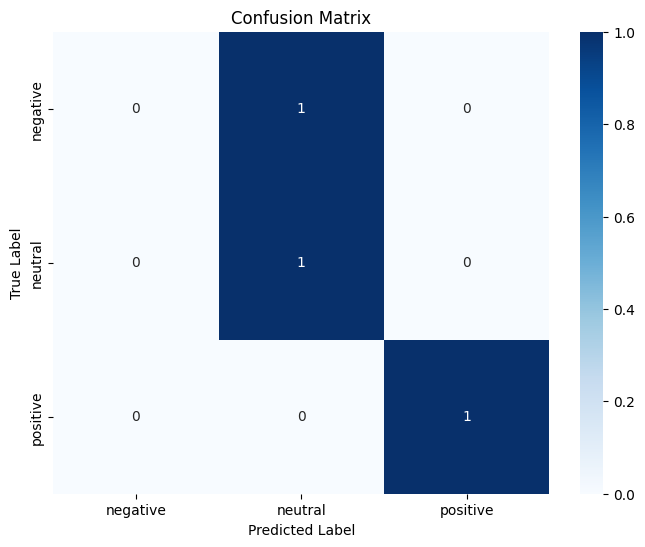

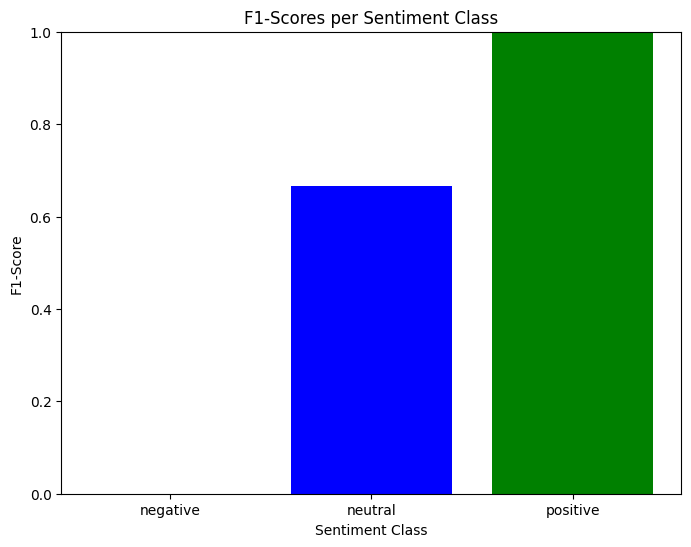

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
plt.figure(figsize=(8, 6))


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)


f1_scores = {
    'negative': report_dict['negative']['f1-score'],
    'neutral': report_dict['neutral']['f1-score'],
    'positive': report_dict['positive']['f1-score']
}

class_names = list(f1_scores.keys())
f1_values = list(f1_scores.values())


plt.figure(figsize=(8, 6))
plt.bar(class_names, f1_values, color=['red', 'blue', 'green'])


plt.title('F1-Scores per Sentiment Class')
plt.xlabel('Sentiment Class')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()